In [1]:
## PRELIMINARIES ##
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Python imports
import sys
sys.path.append('../')
import glob

In [3]:
# Rankutils imports
from rankutils.cfgloader import *
from rankutils.utilities import safe_create_dir, completedir, getbasename
from rankutils.rIO import read_rank
from rankutils.statistical import diff_break_clustering
from rankutils.drawing import colors_from_cmap

In [4]:
# Other imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3

from sklearn.cluster import KMeans, MeanShift, DBSCAN, AffinityPropagation
from sklearn.preprocessing import MinMaxScaler

from jenkspy import jenks_breaks

In [5]:
# Few definitions
min_tail_size = 5
pathcfg = cfgloader('../path_2.cfg')
minmaxscaler = MinMaxScaler((0, 1))

# Rank Clustering Experiment

## Experimental Control Definitions <br>
Variable definitions that control the experiment to be plotted. Below is the descriptions of each one:
 - expkey: controls which experiment to get examples from, in the form `<dataset_key>_<descriptor_key>`
 - k: number of top positions
 - c: number of clusters
 - iidx: Defines which example to be run by its numbering
 - score_type: which score to be read from rank: _dists_ (distances), _normd_ (normalized distances), _votes_ (voting score), _normv_ (normalized votes). For _oxford100k_ and _unicamp100k_ use _votes_, for _places365_, _vggfaces_, and _imagenet_ use _dists_
 - scl: scale the rank to {0, 1} range
 - cvt: convert the rank from distance to similarity

In [6]:
expkey = 'places365_desc1'
k = 10
c = 100
iidx = 1094
score_type = 'dists'   # Controls type of score to be read from rank
scl = False
cvt = False

## Loading and Plotting the Rank
We first load the rank we wish to work with, and plot it as a bar graph. Only the first 1000 positions are used for this experiment, for plotting constraints. The rank can be scaled to $\left \{0, 1 \right \}$ range and converted from distance to similarity. To convert from distance to similarity, we subtract the rank values from the maximum rank value. For _dist_ ranks, a further post processing will be performed: if the first distance is 0, then only the remaining rank is used.

In [7]:
# Loading useful files according to definitions
rkflist = glob.glob(pathcfg['rank'][expkey] + "*.rk")
rkflist.sort()
rkfpath = rkflist[iidx]
rkname = getbasename(rkfpath)

In [8]:
# Loading and performing rank conversions
rank = read_rank(rkfpath, score_type)
if rank[0] == 0:
    rank = rank[1:]

rank = rank[0:1000]
    
if scl:
    rank = minmaxscaler.fit_transform(rank.reshape(-1, 1)).reshape(-1)

if cvt:
    rank = np.max(rank) - rank

## Raw Rank

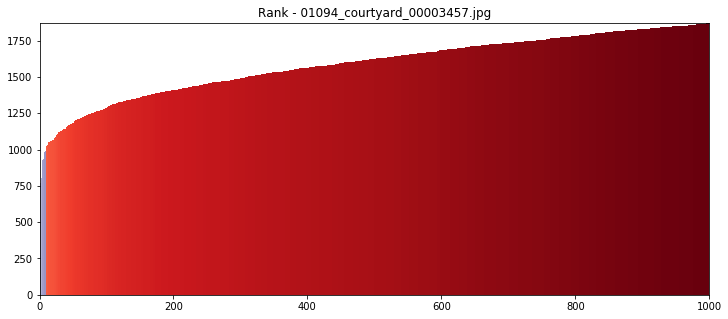

In [9]:
top = rank[0:k]
tail = rank[k:]

x_top = np.arange(0, k, 1, dtype=np.int32)
x_tail = np.arange(k, k+tail.size, 1, dtype=np.int32)

clist_top = colors_from_cmap('Purples', rank, 0.4, 1.0)[0:k]
clist_tail = colors_from_cmap('Reds', rank, 0.4, 1.0)[k:]

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Rank - {0:s}".format(rkname))

rect_top = ax.bar(x_top, top, 1.0, 0.0, align='edge', color=clist_top, label='Top {0:d}   '.format(k))
rect_tail = ax.bar(x_tail, tail, 1.0, 0.0, align='edge', color=clist_tail, label='Tail')

ax.set_xlim(left=0, right=x_tail[-1] + 1)
ax.set_ylim(bottom=0, top=tail[-1])

mpld3.enable_notebook()

## KMeans Clustering

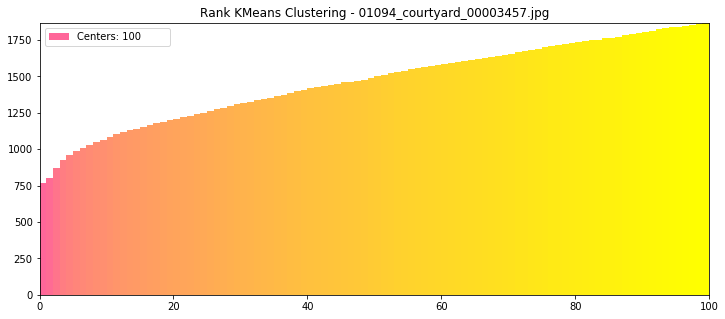

In [10]:
plt.close()

kmn = KMeans(n_clusters=c)
kmn.fit(rank.reshape(-1, 1))

rank_kmn = np.sort(kmn.cluster_centers_.reshape(-1))

clist = colors_from_cmap('spring', rank_kmn, 0.4, 1.0)

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Rank KMeans Clustering - {0:s}".format(rkname))

x = np.arange(rank_kmn.size)
ax.bar(x, rank_kmn, 1.0, 0.0, align='edge', color=clist, label='Centers: {0:d}        '.format(rank_kmn.size))

ax.set_xlim(left=0, right=x[-1]+1)
ax.set_ylim(bottom=0, top=np.max(rank_kmn))

ax.legend()

mpld3.enable_notebook()

## MeanShift Clustering

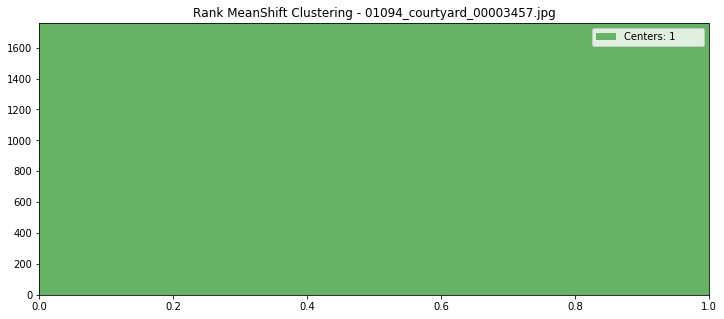

In [11]:
plt.close()

mns = MeanShift()
mns.fit(rank.reshape(-1, 1))

rank_mns = np.sort(mns.cluster_centers_.reshape(-1))

clist = colors_from_cmap('summer', rank_mns, 0.4, 1.0)

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Rank MeanShift Clustering - {0:s}".format(rkname))

x = np.arange(rank_mns.size)
ax.bar(x, rank_mns, 1.0, 0.0, align='edge', color=clist, label='Centers: {0:d}        '.format(rank_mns.size))

ax.set_xlim(left=0, right=x[-1]+1)
ax.set_ylim(bottom=0, top=np.max(rank_mns))

ax.legend()

mpld3.enable_notebook()

## Jenks Breaks Optimization

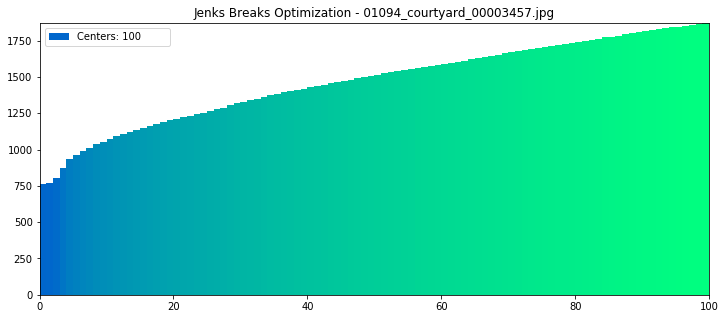

In [12]:
plt.close()

rank_jenks = np.sort(jenks_breaks(rank.reshape(-1), c-1))

clist = colors_from_cmap('winter', rank_jenks, 0.4, 1.0)

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Jenks Breaks Optimization - {0:s}".format(rkname))

x = np.arange(rank_jenks.size)
ax.bar(x, rank_jenks, 1.0, 0.0, align='edge', color=clist, label='Centers: {0:d}        '.format(rank_jenks.size))

ax.set_xlim(left=0, right=x[-1]+1)
ax.set_ylim(bottom=0, top=np.max(rank_jenks))

ax.legend()

mpld3.enable_notebook()

## Diff Break Clustering: 0.0 std dev factor

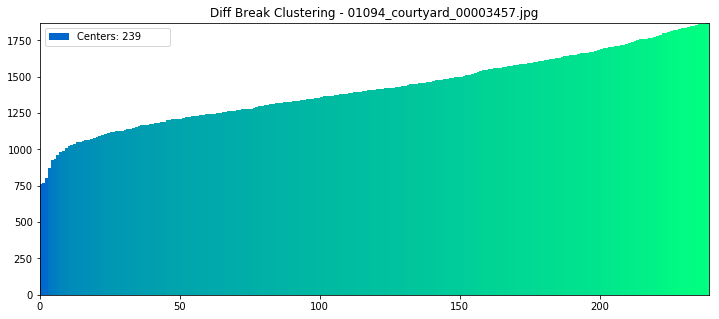

In [13]:
plt.close()

rank_db = np.sort(diff_break_clustering(rank.reshape(-1)))

clist = colors_from_cmap('winter', rank_db, 0.4, 1.0)

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Diff Break Clustering - {0:s}".format(rkname))

x = np.arange(rank_db.size)
ax.bar(x, rank_db, 1.0, 0.0, align='edge', color=clist, label='Centers: {0:d}        '.format(rank_db.size))

ax.set_xlim(left=0, right=x[-1]+1)
ax.set_ylim(bottom=0, top=np.max(rank_db))

ax.legend(loc='upper left')

mpld3.enable_notebook()

## Diff Break Clustering: 0.5 std dev factor

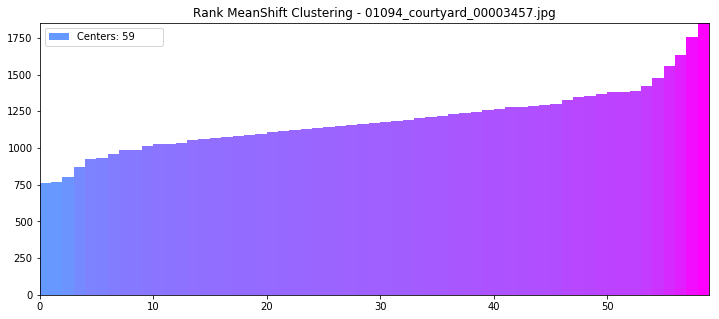

In [14]:
plt.close()

rank_db = np.sort(diff_break_clustering(rank.reshape(-1), 0.5))

clist = colors_from_cmap('cool', rank_db, 0.4, 1.0)

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Rank MeanShift Clustering - {0:s}".format(rkname))

x = np.arange(rank_db.size)
ax.bar(x, rank_db, 1.0, 0.0, align='edge', color=clist, label='Centers: {0:d}        '.format(rank_db.size))

ax.set_xlim(left=0, right=x[-1]+1)
ax.set_ylim(bottom=0, top=np.max(rank_db))

ax.legend(loc='upper left')

mpld3.enable_notebook()

## Diff Break Clustering: -0.5 std dev factor

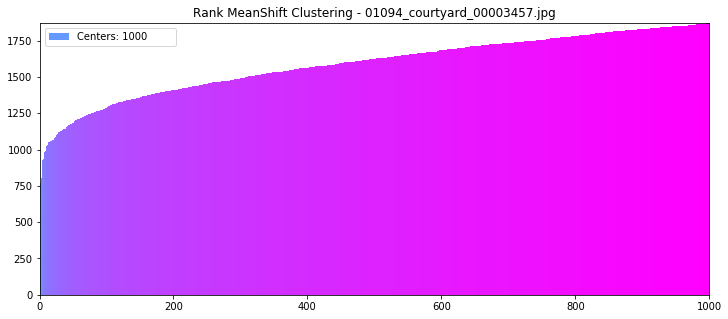

In [15]:
plt.close()

rank_db = np.sort(diff_break_clustering(rank.reshape(-1), -0.5))

clist = colors_from_cmap('cool', rank_db, 0.4, 1.0)

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Rank MeanShift Clustering - {0:s}".format(rkname))

x = np.arange(rank_db.size)
ax.bar(x, rank_db, 1.0, 0.0, align='edge', color=clist, label='Centers: {0:d}        '.format(rank_db.size))

ax.set_xlim(left=0, right=x[-1]+1)
ax.set_ylim(bottom=0, top=np.max(rank_db))

ax.legend(loc='upper left')

mpld3.enable_notebook()

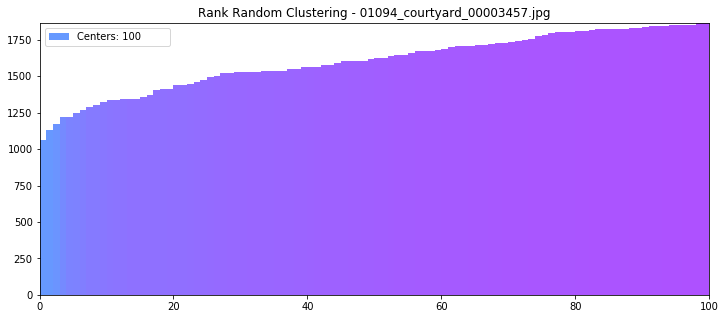

In [22]:
plt.close()

rank_ran = np.sort(np.random.choice(rank, c)).reshape(-1)

clist = colors_from_cmap('cool', rank_db, 0.4, 1.0)

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 5)
ax.set_title("Rank Random Clustering - {0:s}".format(rkname))

x = np.arange(rank_ran.size)
ax.bar(x, rank_ran, 1.0, 0.0, align='edge', color=clist, label='Centers: {0:d}        '.format(rank_ran.size))

ax.set_xlim(left=0, right=x[-1]+1)
ax.set_ylim(bottom=0, top=np.max(rank_ran))

ax.legend(loc='upper left')

mpld3.enable_notebook()